# Sarima Equador

Neste notebook será aplicado o modelo Sarima, ou Arima considerando a sazonalidade, baseado neste artigo no medium (que pode ser acessado aqui) que vai ser aplicado nos casos de morte por Covid no Equador.

In [ ]:
# Importando as blibiotecas
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from itertools import product

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [ ]:
url = 'https://raw.githubusercontent.com/aaasatoou/bootcamp_blue_Projeto2/main/datasets/serie%20temporal%20pais/S%C3%A9ries%20Temporais%20Equador.csv'
serie_equ = pd.read_csv(url)
serie_equ.drop('Unnamed: 0',axis=1,inplace=True)
serie_equ['Date'] = pd.to_datetime(serie_equ['Date'],format='%Y-%m-%d')
serie_equ['Mês'] = serie_equ['Date'].dt.month
serie_equ.set_index('Date',inplace=True)
serie_equ.head()

,Confirmed,Recovered,Deaths,Ano,Mês
Date,,,,,
2020-01-22,0,0.0,0,2020,1
2020-01-23,0,0.0,0,2020,1
2020-01-24,0,0.0,0,2020,1
2020-01-25,0,0.0,0,2020,1
2020-01-26,0,0.0,0,2020,1


In [ ]:
# Separação entre treino e teste
treino = serie_equ[(serie_equ['Ano']<=2021)&(serie_equ['Mês']<12)]
teste = serie_equ[(serie_equ['Ano']==2021)&(serie_equ['Mês'] == 12)]

In [ ]:
def optimize_SARIMA(parameters_list, d, D, s, exog):
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([param, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [ ]:
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 1
Q = range(0, 4, 1)
s = 4
parameters = product(p, q, P, Q)
parameters_list = list(parameters)
print(len(parameters_list))

256


In [ ]:
result_df = optimize_SARIMA(parameters_list, 1, 1, 4, treino['Deaths'])
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q)x(P,Q)",AIC
0,"(0, 0, 0, 1)",9485.174290
1,"(1, 0, 0, 1)",9487.155594
2,"(0, 1, 0, 1)",9487.155695
3,"(0, 0, 1, 1)",9487.172591
4,"(0, 0, 0, 2)",9487.173319
...,...,...
250,"(2, 0, 0, 0)",9916.466139
251,"(0, 3, 0, 0)",9916.785984
252,"(1, 2, 0, 0)",9917.797833
253,"(3, 0, 0, 0)",9918.458247


In [ ]:
best_model = SARIMAX(treino['Deaths'], order=(1, 1, 0), seasonal_order=(1, 2, 1, 4)).fit(dis=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                              Deaths   No. Observations:                  648
Model:             SARIMAX(1, 1, 0)x(1, 2, [1], 4)   Log Likelihood               -4846.214
Date:                             Fri, 16 Dec 2022   AIC                           9700.427
Time:                                     00:24:16   BIC                           9718.267
Sample:                                          0   HQIC                          9707.352
                                             - 648                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0240      0.065     -0.371      0.711      -0.151       0.103
ar.S.L4       -0.4946      

In [ ]:
fc = best_model.forecast(31, alpha=0.05)

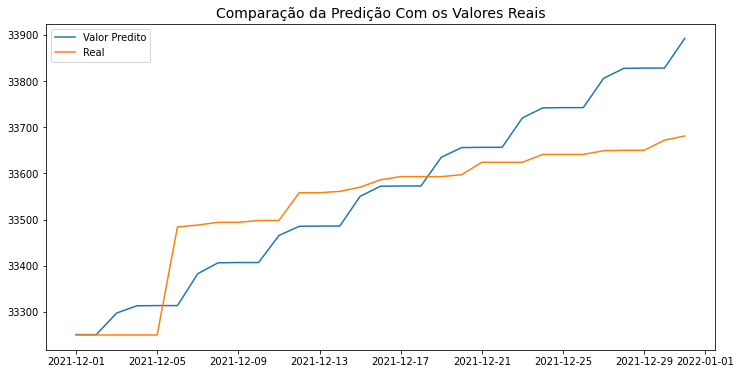

In [ ]:
plt.figure(figsize=(12,6))
plt.title('Comparação da Predição Com os Valores Reais', fontsize=14)
plt.plot(teste.index,fc,label='Valor Predito')
plt.plot(teste.index,teste['Deaths'].values,label='Real')
plt.legend()

In [ ]:
print('MAPE:',mean_absolute_percentage_error(teste['Deaths'],fc))
print('MAE:',mean_absolute_error(teste['Deaths'],fc))
print('RMSE:',np.sqrt(mean_squared_error(teste['Deaths'],fc)))

MAPE: 0.002391223448529629
MAE: 80.28207003576198
RMSE: 97.8097630571002
